In [1]:
import argparse
import chromadb
import pysbd
import uuid
from embedding_functions import get_embedding_fn
from utils import load_dataset

In [2]:
model = "BAAI/bge-small-en"
device = "mps"
embedding_fn = get_embedding_fn(model, device, normalize=False)
print(embedding_fn)

In [3]:
data = load_dataset('data/processed_for_chroma/reviews/Astro_Reviews.json')
print(type(data))
print(len(data))

<class 'list'>
996


In [4]:
# record -> chunking -> use embdding_fn to create insertion records -> insert into db

In [70]:
SEG = pysbd.Segmenter(language="en", clean=False)

def augmented_sentence_embeddings(record, embedding_fn, augmenting_fn):
    """
    Takes a record's body, segments it into sentences, augments each sentence 
    for embedding (such as with title or abstract), and returns a list of tuples 
    of the form (sentence, embedding).

    NOTE: Sentences less than 40 chars are filtered, as these are likely only
    legends, captions, etc. and not full sentences.
    """
    sentences = [s for s in SEG.segment(record['body']) if len(s) > 40]
    texts = augmenting_fn(record, sentences)
    vectors = embedding_fn(texts)
    return sentences, vectors

def add_abstract(record, sentences):
    abstract = record['abstract']
    return [abstract + '\n' + sentence for sentence in sentences]

def add_title(record, sentences):
    title = record['title']
    return [title + '\n' + sentence for sentence in sentences]

def add_title_and_abstract(record, sentences):
    title = record['title']
    abstract = record['abstract']
    return [title + '\n' + abstract + '\n' + sentence for sentence in sentences]

def no_augmentation(record, sentences):
    return sentences

# Insert to DB

For each (augmentation strategy, embedding function, metric) we need to create a collection. The same embedding function can be used for all metrics however

In [71]:
client = chromadb.PersistentClient(path='./vector_stores/test/')

In [72]:
# Delete previous test collections

collections = client.list_collections()
for collection in collections:
    if collection.name.startswith('test'):
        print(f"Deleting collection {collection.name}")
        client.delete_collection(name=collection.name)


Deleting collection test-bge-small-en__l2__add_title
Deleting collection test-bge-small-en__cosine__no_augmentation
Deleting collection test-bge-small-en__cosine__add_title
Deleting collection test-bge-small-en__l2__no_augmentation


In [73]:
# Collection name will be the name of the embedding model-metric-name of augmentation function
from tqdm import tqdm

def create_collection(client, embedding_fn, metric, augmenting_fn):
    # Set up collection name
    model_name = embedding_fn.model_name
    aug_fn = augmenting_fn.__name__
    collection_name = f"test-{model_name}__{metric}__{aug_fn}"

    # Create collection
    print(f"Creating collection: {collection_name}...", end="")
    collection = client.create_collection(
        name=collection_name, 
        embedding_function = embedding_fn,
        metadata={"hnsw:space": metric})
    print("created.")
    return collection

def get_expected_parameters_from_collection_name(collection_name):
    parts = collection_name.split("__")
    # TODO: fix this for the real runs when 'test-' won't prepend each collection name
    model_name = parts[0][5:]
    metric = parts[1]
    augmenting_fn_name = parts[2]
    return model_name, metric, augmenting_fn_name

def insert_records(collection, records, embedding_fn, augmenting_fn):
    # Ensure the passed in embedding function and augmenting function match the collection's expected functions
    model_name, metric, augmenting_fn_name = get_expected_parameters_from_collection_name(collection.name)
    assert model_name == embedding_fn.model_name, f"Expected embedding model '{model_name}' for collection {collection.name} but got '{embedding_fn.model_name}'"
    assert augmenting_fn_name == augmenting_fn.__name__, f"Expected augmentation function '{augmenting_fn_name}' for {collection.name} but got '{augmenting_fn.__name__}'"

    count = collection.count()

    # Insert records
    for record in tqdm(records):
        sentences, vectors = augmented_sentence_embeddings(record, embedding_fn, augmenting_fn)
        ids = [str(uuid.uuid4()) for _ in sentences]
        doi = record['doi'][0]
        collection.add(
            documents=sentences,
            metadatas=[{'doi': doi}] * len(sentences),
            embeddings=vectors,
            ids=ids
        )

    print(f"Added {collection.count() - count} records to collection {collection.name}")
    

In [74]:
import itertools
augmenting_functions = [no_augmentation, add_title]
metrics = ['cosine', 'l2']
collections = [create_collection(client, embedding_fn, metric, augmenting_fn) for augmenting_fn, metric in itertools.product(augmenting_functions, metrics)]


Creating collection: test-bge-small-en__cosine__no_augmentation...created.
Creating collection: test-bge-small-en__l2__no_augmentation...created.
Creating collection: test-bge-small-en__cosine__add_title...created.
Creating collection: test-bge-small-en__l2__add_title...created.


In [75]:
collection = collections[-1]
print(collection)
insert_records(collection, data[:2], embedding_fn, add_title)

Collection(name=test-bge-small-en__l2__add_title)


100%|██████████| 2/2 [00:11<00:00,  5.83s/it]

Added 1822 records to collection test-bge-small-en__l2__add_title


In [76]:
results = collection.query(
    query_texts=["is solar chemical composition important for astronomy?"],
    n_results=6,
    include=['documents', 'metadatas']
)

In [77]:
print(results['documents'])

[['4. OTHER METHODS FOR INFERRING SOLAR ABUNDANCES 4.1. ', '2. INGREDIENTS FOR SOLAR ABUNDANCE ANALYSIS 2.1. ', 'Table 3 Representative isotopic abundance fractions in the Solar System. ', 'It is therefore timely to now critically assess the reference solar chemical composition and make recommendations regarding the most accurate values available to the astronomical community. ', 'In addition, photoionization cross sections play a crucial role. ', 'The importance of having accurate solar elemental abundances thus can not be overstated. ']]


(array([ 73.,  57., 126., 153., 119.,  80.,  44.,  28.,   8.,   7.,   2.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([  5.  ,  48.15,  91.3 , 134.45, 177.6 , 220.75, 263.9 , 307.05,
        350.2 , 393.35, 436.5 , 479.65, 522.8 , 565.95, 609.1 , 652.25,
        695.4 , 738.55, 781.7 , 824.85, 868.  ]),
 <BarContainer object of 20 artists>)

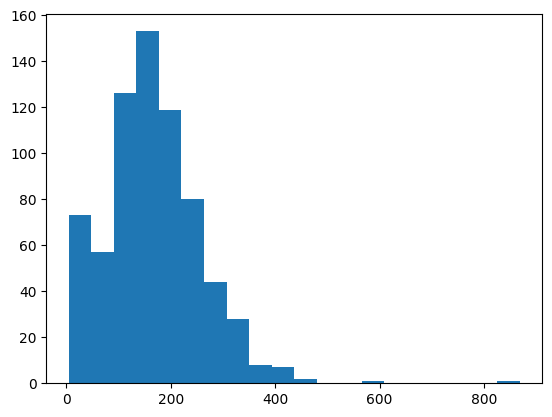

In [ ]:

sentences = SEG.segment(data[0]['body'])
lengths = [len(s) for s in sentences]

# create a histogram of these lengths
import matplotlib.pyplot as plt
plt.hist(lengths, bins=20)

In [64]:
sorted_lengths = sorted(sentences, key=len)


In [69]:
for i, s in enumerate(sorted_lengths):
    print(i, len(s), s)

0 5 2.2. 
1 5 2.3. 
2 5 2.4. 
3 5 3.1. 
4 5 3.2. 
5 5 3.3. 
6 5 3.4. 
7 5 3.5. 
8 5 3.6. 
9 5 3.7. 
10 5 3.8. 
11 5 3.9. 
12 5 4.2. 
13 5 4.3. 
14 5 4.4. 
15 5 5.2. 
16 6 Iron. 
17 6 ( b ) 
18 6 Neon. 
19 6 3.10. 
20 6 3.11. 
21 6 3.12. 
22 7 3.1.2. 
23 7 3.1.3. 
24 7 Boron. 
25 7 3.5.2. 
26 7 3.5.3. 
27 7 3.5.4. 
28 7 3.5.6. 
29 7 3.5.7. 
30 7 3.5.8. 
31 7 3.5.9. 
32 7 3.6.2. 
33 7 3.6.3. 
34 7 3.6.4. 
35 7 3.6.5. 
36 7 3.6.6. 
37 7 3.6.7. 
38 7 3.6.8. 
39 7 3.9.1. 
40 7 3.9.2. 
41 7 3.9.3. 
42 7 Argon. 
43 7 3.9.4. 
44 7 3.9.5. 
45 7 Xenon. 
46 8 Sodium. 
47 8 Sulfur. 
48 8 Cobalt. 
49 8 Nickel. 
50 8 Helium. 
51 9 Lithium. 
52 9 Silicon. 
53 9 Calcium. 
54 9 Krypton. 
55 10 Aluminum. 
56 10 Scandium. 
57 10 Titanium. 
58 10 Vanadium. 
59 10 Chromium. 
60 11 Beryllium. 
61 11 Magnesium. 
62 11 Potassium. 
63 11 Manganese. 
64 12 Phosphorus. 
65 16 c Present work. 
66 26 Iron-Peak Elements 3.6.1. 
67 27 b Grevesse Sauval (1998) . 
68 27 5. CONCLUDING REMARKS 5.1. 
69 34 Intermediate M

In [79]:
''.join(sentences[max(-2, 0):2])

'1. INTRODUCTION The solar chemical composition is a fundamental yardstick in astronomy, to which the elemental abundances of essentially all cosmic objects, be they planets, stars, nebulae or galaxies, are anchored. The importance of having accurate solar elemental abundances thus can not be overstated. '